In [2]:
import os
import numpy as np
from PIL import Image
from mtcnn import MTCNN
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model

In [12]:
# Preprocess images and extract faces using MTCNN (handles folders)
def extract_faces_with_augmentation(images_folder, datagen=None):
    detector = MTCNN()
    face_data = []
    labels = []

    # Go through each class/person folder
    for class_name in os.listdir(images_folder):
        class_path = os.path.join(images_folder, class_name)

        if not os.path.isdir(class_path):
            continue  # Skip non-folder files

        # Loop through images inside the class folder
        for image_name in os.listdir(class_path):
            img_path = os.path.join(class_path, image_name)

            # Skip anything that's not a file
            if not os.path.isfile(img_path):
                continue

            try:
                image = Image.open(img_path)
            except Exception as e:
                print(f"Error opening {img_path}: {e}")
                continue

            faces = detector.detect_faces(np.array(image))
            if len(faces) > 0:
                x, y, w, h = faces[0]['box']
                face = image.crop((x, y, x + w, y + h)).resize((160, 160))

                if datagen is not None:
                    for _ in range(20):
                        augmented = next(datagen.flow(np.array(face).reshape(1, 160, 160, 3), batch_size=1))
                        for aug_face in augmented:
                            face_data.append(aug_face)
                            labels.append(class_name)
                else:
                    face_data.append(np.array(face))
                    labels.append(class_name)

    return np.array(face_data), labels


In [4]:
import os
import shutil
import random

# Set paths
source_dir = 'C:/Users/K OMGANESH/Downloads/project3/Celebrity Faces Dataset'
train_dir = 'C:/Users/K OMGANESH/Downloads/project3/train_set'
val_dir = 'C:/Users/K OMGANESH/Downloads/project3/val_set'

# Create destination folders if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Set seed for reproducibility
random.seed(42)

# Loop through each class folder
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Get all image file paths
    images = [
        img for img in os.listdir(class_path)
        if img.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

    # Shuffle the image list
    random.shuffle(images)

    # Calculate split index
    split_index = int(len(images) * 0.7)
    train_images = images[:split_index]
    val_images = images[split_index:]

    # Create class folders in train and val
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    # Copy train images
    for img in train_images:
        src_path = os.path.join(class_path, img)
        dst_path = os.path.join(train_dir, class_name, img)
        shutil.copy2(src_path, dst_path)

    # Copy val images
    for img in val_images:
        src_path = os.path.join(class_path, img)
        dst_path = os.path.join(val_dir, class_name, img)
        shutil.copy2(src_path, dst_path)

print("Dataset successfully split into train and val folders.")


Dataset successfully split into train and val folders.


In [13]:
# Paths to training and testing image folders
train_folder = "train_set"
test_folder = "val_set"
# Create data augmentation generator for training data
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.75, 1.25],
    fill_mode='nearest'
)

# Extract faces with data augmentation for training images
print("Extract faces & apply data augmentation for training images:")
train_images, train_labels = extract_faces_with_augmentation(train_folder, datagen)

Extract faces & apply data augmentation for training images:


In [ ]:
#Verify and ploting the training augmented images with labels
# Calculate the number of rows and columns for the subplot grid
num_images = len(train_images)
num_columns = 5
num_rows = (num_images + num_columns - 1) // num_columns
fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 200))
for i, ax in enumerate(axes.flatten()):
    if i < num_images:
        image = train_images[i].astype(np.uint8)  # Convert image to uint8
        ax.imshow(image,cmap='gray')
        ax.set_title("Train Image: " + train_labels[i], fontsize=8)
        ax.axis("off")
    else:
        ax.axis("off")
plt.tight_layout()
plt.show()

In [18]:
pip install keras-facenet

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10387 sha256=e5ace89d31f822193db902501641a296a161e501f3faf63160ac117060ac0fbe
  Stored in directory: c:\users\k omganesh\appdata\local\pip\cache\wheels\99\94\dd\cb1a65a7440ba6d508bd24346c15af0b1d24ff8b1cdb1c9959
Successfully built keras-facenet
Note: you may need to restart the kernel to use updated packages.


In [19]:
from keras_facenet import FaceNet

# 1. Load the pre-wrapped FaceNet model
embedder = FaceNet()
facenet_model = embedder.model  # This is a Keras model

# 2. Define your embedding function
def get_face_embeddings(facenet_model, face_images):
    embeddings = []
    for face_image in face_images:
        img = tf.image.resize(face_image, (160, 160))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = img / 255.0  # Normalize pixel values
        embedding = facenet_model.predict(img)
        embeddings.append(embedding[0])
    return np.array(embeddings)

# 3. Get embeddings
print("Get face embeddings training images using FaceNet from keras-facenet:")
embeddings = get_face_embeddings(facenet_model, train_images)

# 4. Save embeddings and labels
np.save("C:/Users/K OMGANESH/Downloads/project3/embeddings.npy", embeddings)
np.save("C:/Users/K OMGANESH/Downloads/project3/train_labels.npy", train_labels)


Get face embeddings training images using FaceNet from keras-facenet:
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms

In [20]:
# Create a label encoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
num_classes = len(label_encoder.classes_)
# Save the label encoder classes to a file for later use
np.save("C:/Users/K OMGANESH/Downloads/project3/label_encoder_classes.npy", label_encoder.classes_)

In [21]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Function to test a model and display results
def test_model(model, model_name, test_folder, label_encoder):
    
    test_images, test_labels = extract_faces_with_augmentation(test_folder)
    test_labels_encoded = label_encoder.transform(test_labels)
    
    # Get face embeddings for test images using Facenet
    test_embeddings = get_face_embeddings(facenet_model, test_images)

    # Reshape the input data to add the third dimension
    test_embeddings_reshaped = np.expand_dims(test_embeddings, axis=-1)
    
    # Predict labels using the trained model
    predictions = model.predict(test_embeddings_reshaped)
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(test_labels_encoded, predicted_labels)
    print(f"{model_name} Model Accuracy: {accuracy:.2f}")

    # Display test images with predicted and actual labels
    num_test_images = len(test_images)
    num_columns = 5
    num_rows = np.ceil(num_test_images / num_columns).astype(int)  # Ceiling division
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 12))
    for i, ax in enumerate(axes.flatten()):
        if i < num_test_images:
            ax.imshow(test_images[i])
            actual_label = test_labels[i]
            predicted_label = label_encoder.classes_[predicted_labels[i]]
            text_color = 'green' if actual_label == predicted_label else 'red'
            ax.set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}", color=text_color)
            ax.axis("off")
        else:
            ax.axis("off")
    plt.tight_layout()
    plt.show()
    
    # Calculate and display classification report
    print(f"\nClassification Report for {model_name} Model:")
    print(classification_report(test_labels, label_encoder.classes_[predicted_labels], zero_division=1.0))

    # Calculate and display confusion matrix
    print(f"\nConfusion Matrix for {model_name} Model:")
    cm = confusion_matrix(test_labels, label_encoder.classes_[predicted_labels])
    print(cm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

C:\Users\K OMGANESH\AppData\Local\Temp\ipykernel_23428\3849363688.py:42: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


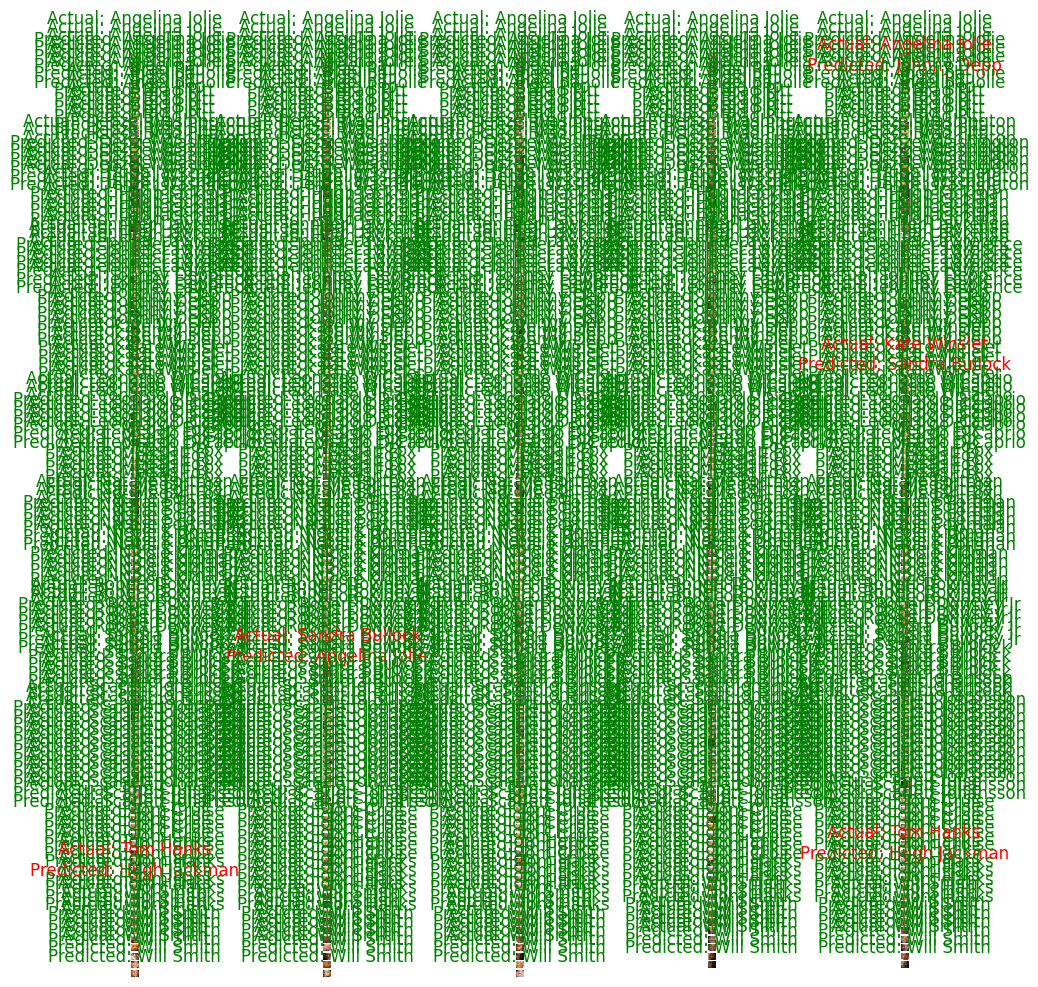


Classification Report for ResNet Model:
                    precision    recall  f1-score   support

    Angelina Jolie       0.97      0.97      0.97        30
         Brad Pitt       1.00      1.00      1.00        30
 Denzel Washington       1.00      1.00      1.00        30
      Hugh Jackman       0.94      1.00      0.97        30
 Jennifer Lawrence       1.00      1.00      1.00        30
       Johnny Depp       0.97      1.00      0.98        30
      Kate Winslet       1.00      0.97      0.98        30
 Leonardo DiCaprio       1.00      1.00      1.00        30
         Megan Fox       1.00      1.00      1.00        30
   Natalie Portman       1.00      1.00      1.00        30
     Nicole Kidman       1.00      1.00      1.00        30
  Robert Downey Jr       1.00      1.00      1.00        29
    Sandra Bullock       0.97      0.97      0.97        30
Scarlett Johansson       1.00      1.00      1.00        60
        Tom Cruise       1.00      1.00      1.00        3

In [22]:
# Load the trained ResNet model
trained_resnet_model = tf.keras.models.load_model("C:/Users/K OMGANESH/Downloads/resnet_model.keras")

# Load label encoder classes
label_encoder_classes = np.load("C:/Users/K OMGANESH/Downloads/project3/label_encoder_classes.npy")
label_encoder = LabelEncoder()
label_encoder.classes_ = label_encoder_classes

# Test the ResNet model with test images
test_model(trained_resnet_model, "ResNet", test_folder, label_encoder)